#### To-do:
- A bit of thinking
- Data Exploration
- Data Preprocessing (NaNs, Pipeline building (numerical, categorical, both))
- Trying promising models
- Selecting the best model
- Evaluate Test Set

#### Let's think...
It's clearly a regression problem, the dataset is small, but complex.<br>
1460 samples is a little number of samples.<br>
It's a univariate regression task, so models worth trying are:<br>
- Linear Regression with Regularizers(poor performance expected)
- SVM with non-linear kernels
- RandomForestRegressor
- Gradient Boosting

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

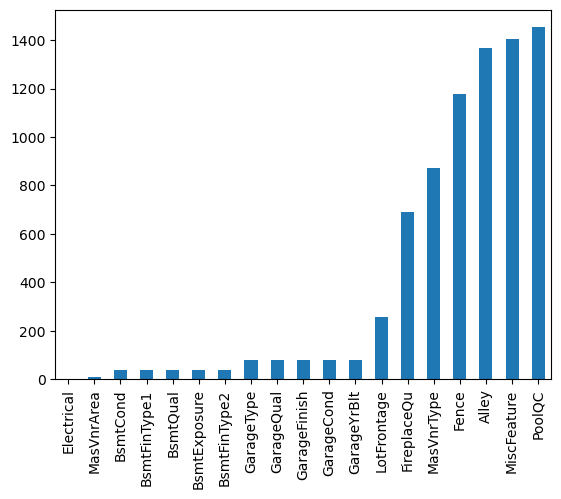

In [26]:
missing = train_df.isna().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot(kind='bar');

In [36]:
import scipy.stats as stats

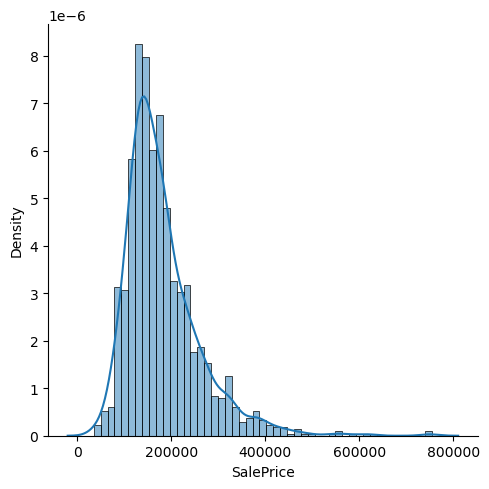

In [42]:
sns.displot(train_df["SalePrice"], kde=True, stat="density", kde_kws=dict(cut=3));

In [58]:
def plot_dist(feature, stat, title=""):
    sns.displot(train_df[feature], kde=True, stat="density")

    # Fit a normal distribution
    params = stat.fit(train_df[feature])
    x = np.linspace(0, train_df[feature].max(), 100)
    p = stat.pdf(x, *params)
    plt.title(title)
    plt.plot(x, p, 'r', linewidth=2, label='Stat fit')
    plt.legend();

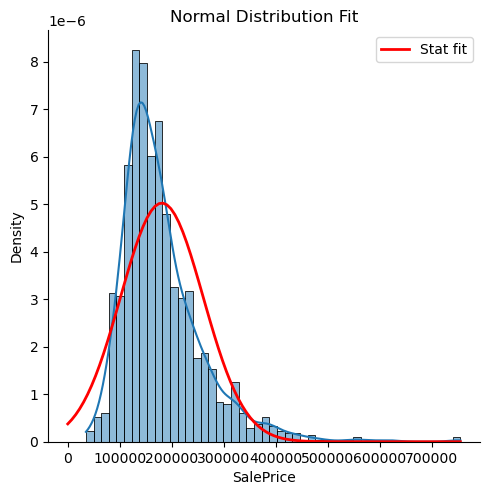

In [60]:
plot_dist("SalePrice", stats.norm, title="Normal Distribution Fit")

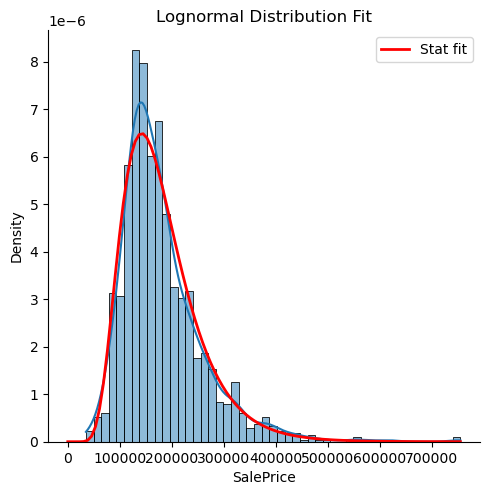

In [61]:
plot_dist("SalePrice", stats.lognorm, title="Lognormal Distribution Fit")

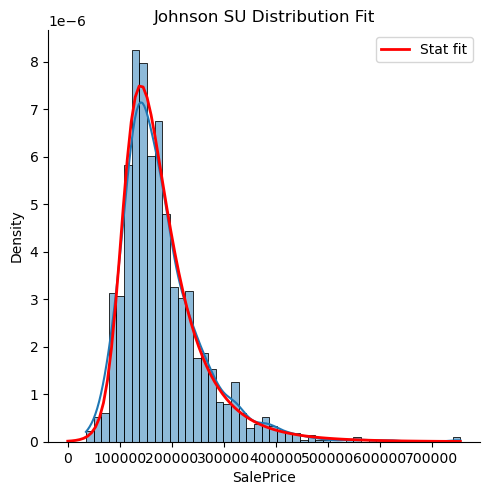

In [63]:
plot_dist("SalePrice", stats.johnsonsu, title="Johnson SU Distribution Fit")

Johnson's Su distribution fits the best.<br>
As we can see, this data is skewed (positively), it deviates from normal distribution and it is peaked.

In [68]:
print(f"Skewness: {train_df["SalePrice"].skew():.4f}")
print(f"Kurtosis: {train_df["SalePrice"].kurt():.4f}")

Skewness: 1.8829
Kurtosis: 6.5363


Relationship with numerical variables

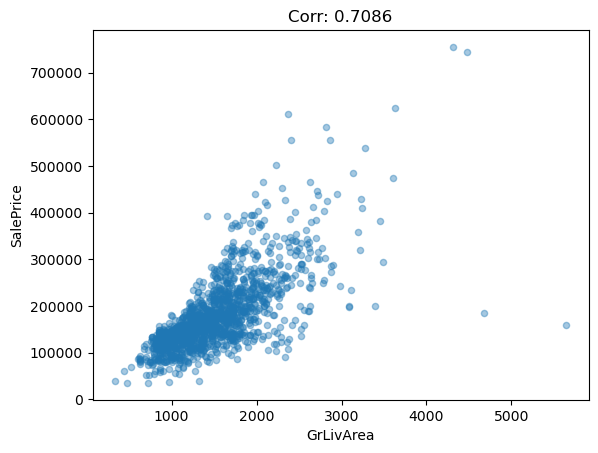

In [80]:
def plot_num_relationship(var):
    data = pd.concat([train_df["SalePrice"], train_df[var]], axis=1)
    title = f"Corr: {data.corr()["SalePrice"][var]:.4f}"
    data.plot.scatter(x=var, y="SalePrice", title=title, alpha=0.4)

# Living area in square feet (promising)
plot_num_relationship("GrLivArea")

Okay! Looks promising. It's a linear relationship with a positive correlation!

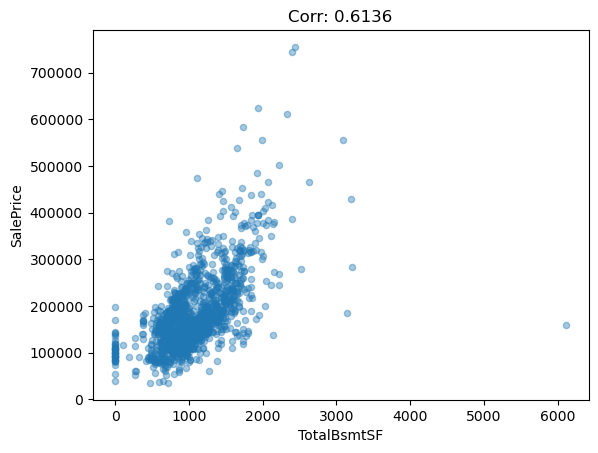

In [81]:
# Basement SquareFeet
plot_num_relationship("TotalBsmtSF")

Also good enough, but correlation here is smaller

In [88]:
def plot_cat_relationship(var, figsize=(8, 6)):
    data = pd.concat([train_df["SalePrice"], train_df[var]], axis=1)
    f, ax = plt.subplots(figsize=figsize)
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    if train_df[var].nunique() > 30:
        plt.xticks(rotation=90)

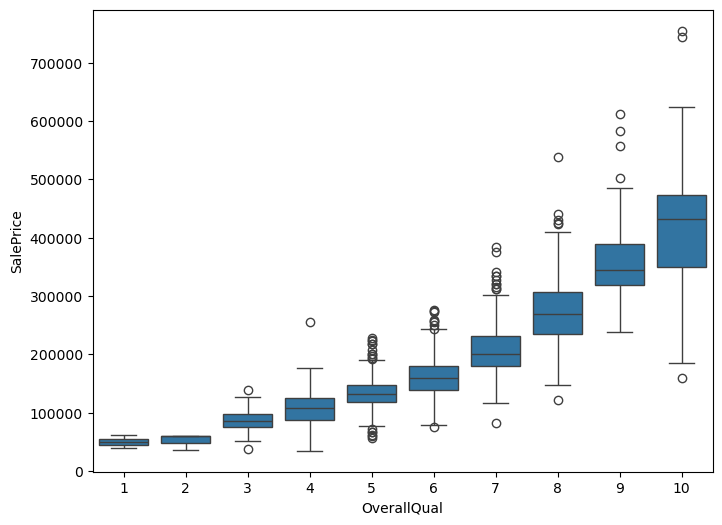

In [89]:
plot_cat_relationship("OverallQual")

Well, as expected. The better the overall quality of the building, the higher the price (there are some outliers, but generally it's fine).

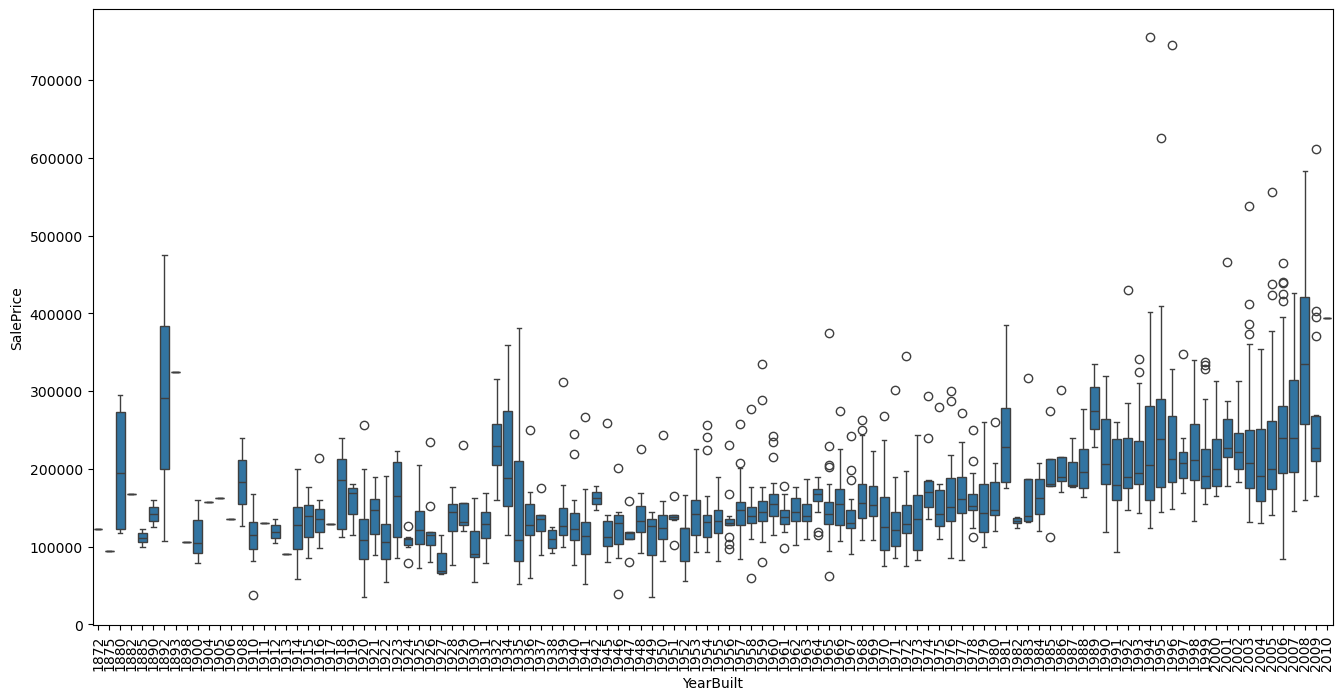

In [90]:
plot_cat_relationship("YearBuilt", figsize=(16, 8))

Interesting... Overall it's a gentle positive trend (the newer the object is, the more it costs), but very old buildings are considered retro gems and cost as much as new ones

But this is very subjective.<br>
We checked the variables we found interesting enough.<br>
Let's act more professionally and see the correlation heatmap!

In [95]:
train_df["SalePrice"]

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

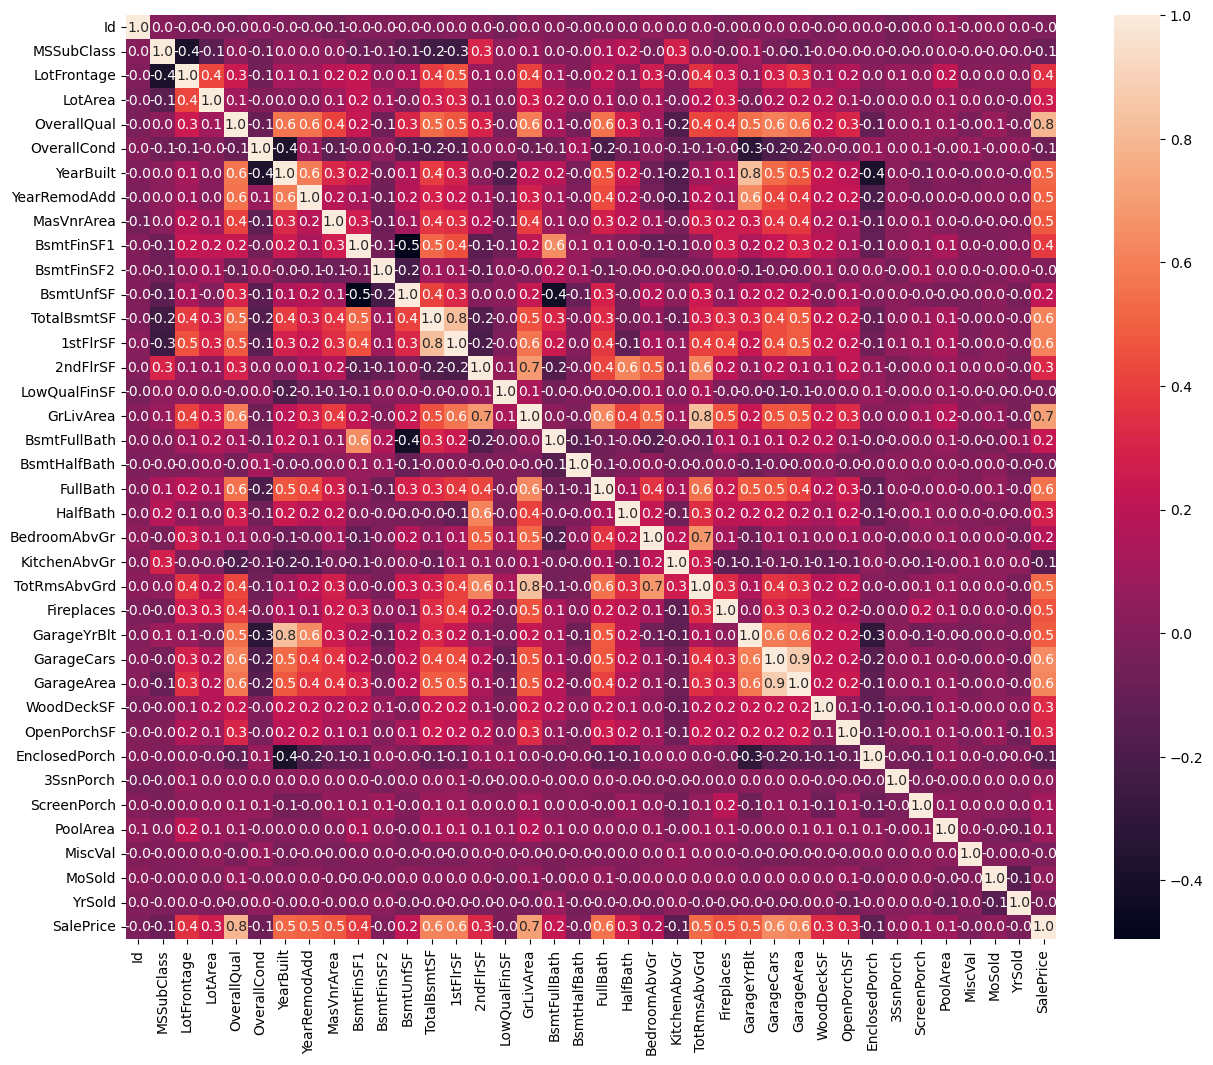

In [106]:
corrmat = train_df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, annot=True, fmt=f".1f");

Note: low correlation doesn't mean no pattern. There's a possibility that the pattern is non-linear.